In [1]:
import torch
import torch.nn as nn
import numpy as np
from  scipy.ndimage import zoom as imzoom
import sys
import os
%matplotlib inline

from PIL import Image
from matplotlib import mlab
import matplotlib.pyplot as plt
import numpy as np

#Training....
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.optim as optim
from tqdm import tqdm





from SpatialTransformer2D import SpatialTransformer2d
from HardNet import HardNet
hardnet = HardNet()
checkpoint = torch.load('HardNetLib.pth')
hardnet.load_state_dict(checkpoint['state_dict'])


In [2]:
class SparseImgRepresenter(nn.Module):
    def __init__(self, 
             detector_net = None,
             descriptor_net = None,    
             use_cuda = False):
        super(SparseImgRepresenter, self).__init__()
        self.detector = detector_net;
        self.descriptor = descriptor_net;
        return
    def forward(self, input_img):
        aff_norm_patches, LAFs = self.detector(input_img)
        descs = self.descriptor(aff_norm_patches);
        return aff_norm_patches, LAFs, descs

ConvST_net = SpatialTransformer2d( num_input_channels = 1,
                 feature_net = None,
                 out_patch_size = 32,
                 out_stride = 32,
                 min_zoom = 0.7,
                 max_zoom = 1.3,
                 min_tilt = 0.8,
                 max_tilt = 1.2,
                 max_rot = 1.0,
                 max_shift = 0.1,
                 mrSize = 1.0, use_cuda = True)

SIRNet = SparseImgRepresenter(detector_net = ConvST_net, descriptor_net = hardnet)

#aff_norm_patches, LAFs, descs = SIRNet(var_image_reshape)

def distance_matrix_vector(anchor, positive):
    """Given batch of anchor descriptors and positive descriptors calculate distance matrix"""

    d1_sq = torch.sum(anchor * anchor, dim=1)
    d2_sq = torch.sum(positive * positive, dim=1)
    eps = 1e-6
    return torch.sqrt((d1_sq.expand(anchor.size(0), anchor.size(0)) + torch.t(d2_sq.expand(positive.size(0), positive.size(0)))
                      - 2.0 * torch.bmm(positive.unsqueeze(0), torch.t(anchor).unsqueeze(0)).squeeze(0))+eps)
def LAFs_to_H_frames(aff_pts, use_cuda = False):
    H3_x = torch.Tensor([0, 0, 1 ]).unsqueeze(0).unsqueeze(0).expand_as(aff_pts[:,0:1,:]);
    H3_x = torch.autograd.Variable(H3_x)
    if use_cuda:
        H3_x = H3_x.cuda()
    return torch.cat([aff_pts, H3_x], dim = 1)
def get_GT_correspondence_indexes(aff_pts1,aff_pts2, H1to2, dist_threshold = 4, use_cuda = False):
    LHF2 = LAFs_to_H_frames(aff_pts2, use_cuda = use_cuda)
    LHF2_reprojected_to_1 = torch.bmm(H1to2.unsqueeze(0).expand_as(LHF2), LHF2);
    LHF2_reprojected_to_1 = LHF2_reprojected_to_1 / LHF2_reprojected_to_1[:,2:,2:].expand_as(LHF2_reprojected_to_1);
    just_centers1 = aff_pts1[:,:,2];
    just_centers2_repr_to_1 = LHF2_reprojected_to_1[:,0:2,2];
    dist  = distance_matrix_vector(just_centers1, just_centers2_repr_to_1)
    min_dist, idxs_in_2 = torch.min(dist,1)
    plain_indxs_in1 = torch.autograd.Variable(torch.arange(0, idxs_in_2.size(0)))
    if use_cuda:
        plain_indxs_in1 = plain_indxs_in1.cuda()
    mask =  min_dist <= dist_threshold
    return min_dist[mask], plain_indxs_in1[mask], idxs_in_2[mask]



In [3]:

def adjust_learning_rate(optimizer):
    """Updates the learning rate given the learning rate decay.
    The routine has been implemented according to the original Lua SGD optimizer
    """
    n_triplets = 116*5.
    n_epochs = 10.
    for group in optimizer.param_groups:
        if 'step' not in group:
            group['step'] = 0.
        else:
            group['step'] += 1.
        group['lr'] =  0.01 * (
        1.0 - float(group['step']) * float(1.0) / (n_triplets * float(n_epochs)))
    return

def create_optimizer(model, new_lr, wd):
    # setup optimizer
    optimizer = optim.SGD(model.parameters(), lr=new_lr,
                          momentum=0.9, dampening=0.9,
                          weight_decay=wd)
    return optimizer

def create_loaders(load_random_triplets = False):

    kwargs = {'num_workers': 2, 'pin_memory': True} if True else {}

    transform = transforms.Compose([
            transforms.ToTensor()])
    #        transforms.Normalize((args.mean_image,), (args.std_image,))])

    train_loader = torch.utils.data.DataLoader(
            dset.HPatchesSeq('/home/old-ufo/dev/LearnedDetector/dataset', 'a',
                             train=True, transform=None, 
                             download=True), batch_size = 1,
        shuffle = True, **kwargs)

    test_loader = torch.utils.data.DataLoader(
            dset.HPatchesSeq('/home/old-ufo/dev/LearnedDetector/dataset', 'a',
                             train=False, transform=None, 
                             download=True), batch_size = 1,
        shuffle = False, **kwargs)

    return train_loader, test_loader

In [4]:

def train(train_loader, model, optimizer, epoch, cuda = True):
    # switch to train mode
    model.train()
    log_interval = 1
    spatial_only = True
    pbar = tqdm(enumerate(train_loader))
    loss_function =  nn.MSELoss()
    for batch_idx, data in pbar:
        img1, img2, H  = data
        img1 = img1.float().squeeze(0)
        img2 = img2.float().squeeze(0)
        if cuda:
            img1, img2, H = img1.cuda(), img2.cuda(), H.cuda()
        img1, img2, H = Variable(img1), Variable(img2), Variable(H)
        aff_norm_patches1, LAFs1, descs1 = model(img1)
        aff_norm_patches2, LAFs2, descs2 = model(img2)
        spatial_dists, idxs_in1, idxs_in2 = get_GT_correspondence_indexes(LAFs1, LAFs2, H, dist_threshold = 10, use_cuda = cuda);
        if spatial_only:
            target =  Variable(torch.zeros_like(spatial_dists).cuda())
            loss = loss_function(spatial_dists,target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        adjust_learning_rate(optimizer)
        if batch_idx % alog_interval == 0:
            pbar.set_description(
                'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data_a), len(train_loader.dataset),
                           100. * batch_idx / len(train_loader),
                    loss.data[0]))

    torch.save({'epoch': epoch + 1, 'state_dict': model.state_dict()},
               '{}/checkpoint_{}.pth'.format(LOG_DIR, epoch))


In [5]:
model = SIRNet
train_loader, test_loader = create_loaders()
model = model.cuda()

optimizer1 = create_optimizer(model.detector, 0.01, 1e-4)


# Found cached data /home/old-ufo/dev/LearnedDetector/dataset/hpatches-sequences-release_a_train.pt
# Found cached data /home/old-ufo/dev/LearnedDetector/dataset/hpatches-sequences-release_a_test.pt


(1058, 1411)
(1411, 1058)
(3, 3)


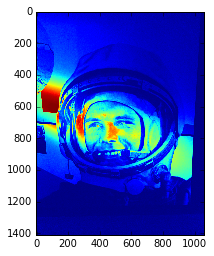

In [6]:
def PIL2array(_img):
    """Convert PIL image type to numpy 2D array
    """
    return np.array(_img.getdata(), dtype=np.uint8).squeeze()
    
img_fname = '/home/old-ufo/dev/LearnedDetector/dataset/hpatches-sequences-release/v_yuri/1.ppm'
image = Image.open(img_fname)
print image.size
warped_img = np.array(image).mean(axis = 2)
plt.imshow(warped_img)
print warped_img.shape

h_fname = '/home/old-ufo/dev/LearnedDetector/dataset/hpatches-sequences-release/v_yuri/H_1_3'
H = np.loadtxt(h_fname)
print H.shape

In [7]:
start = 0
end = 10
for epoch in range(start, end):
    print 'epoch', epoch
    model = model.cuda()
    train(train_loader, model, optimizer1, epoch, cuda = True)

epoch 0


0it [00:00, ?it/s]

RuntimeError: cuda runtime error (2) : out of memory at /home/old-ufo/dev/pytorch/torch/lib/THC/generic/THCStorage.cu:66

In [ ]:

def test(test_loader, model, epoch, logger, logger_test_name):
    # switch to evaluate mode
    model.eval()

    labels, distances = [], []

    pbar = tqdm(enumerate(test_loader))
    for batch_idx, (data_a, data_p, label) in pbar:

        if args.cuda:
            data_a, data_p = data_a.cuda(), data_p.cuda()

        data_a, data_p, label = Variable(data_a, volatile=True), \
                                Variable(data_p, volatile=True), Variable(label)

        out_a, out_p = model(data_a), model(data_p)
        dists = torch.sqrt(torch.sum((out_a - out_p) ** 2, 1))  # euclidean distance
        distances.append(dists.data.cpu().numpy().reshape(-1,1))
        ll = label.data.cpu().numpy().reshape(-1, 1)
        labels.append(ll)

        if batch_idx % args.log_interval == 0:
            pbar.set_description(logger_test_name+' Test Epoch: {} [{}/{} ({:.0f}%)]'.format(
                epoch, batch_idx * len(data_a), len(test_loader.dataset),
                       100. * batch_idx / len(test_loader)))

    num_tests = test_loader.dataset.matches.size(0)
    labels = np.vstack(labels).reshape(num_tests)
    distances = np.vstack(distances).reshape(num_tests)

    fpr95 = ErrorRateAt95Recall(labels, 1.0 / (distances + 1e-8))
    print('\33[91mTest set: Accuracy(FPR95): {:.8f}\n\33[0m'.format(fpr95))

    if (args.enable_logging):
        logger.log_value(logger_test_name+' fpr95', fpr95)
    return

In [13]:



def main(train_loader, test_loaders, model, logger, file_logger):
    # print the experiment configuration
    print('\nparsed options:\n{}\n'.format(vars(args)))

    if (args.enable_logging):
        file_logger.log_string('logs.txt', '\nparsed options:\n{}\n'.format(vars(args)))

    if args.cuda:
        model.cuda()

    optimizer1 = create_optimizer(model.features, args.lr)

    # optionally resume from a checkpoint
    if args.resume:
        if os.path.isfile(args.resume):
            print('=> loading checkpoint {}'.format(args.resume))
            checkpoint = torch.load(args.resume)
            args.start_epoch = checkpoint['epoch']
            checkpoint = torch.load(args.resume)
            model.load_state_dict(checkpoint['state_dict'])
        else:
            print('=> no checkpoint found at {}'.format(args.resume))
    load_random_triplets = args.batch_reduce == 'random_global'
    start = args.start_epoch
    end = start + args.epochs
    for epoch in range(start, end):
        # iterate over test loaders and test results
        for test_loader in test_loaders:
            test(test_loader['dataloader'], model, epoch, logger, test_loader['name'])
        train(train_loader, model, optimizer1, epoch, logger, load_random_triplets)
        if TEST_ON_W1BS :
            # print(weights_path)
            patch_images = w1bs.get_list_of_patch_images(
                DATASET_DIR=args.w1bsroot.replace('/code', '/data/W1BS'))
            desc_name = 'curr_desc'# + str(random.randint(0,100))
            
            DESCS_DIR = LOG_DIR + '/temp_descs/' #args.w1bsroot.replace('/code', "/data/out_descriptors")
            OUT_DIR = DESCS_DIR.replace('/temp_descs/', "/out_graphs/")

            for img_fname in patch_images:
                w1bs_extract_descs_and_save(img_fname, model, desc_name, cuda = args.cuda,
                                            mean_img=args.mean_image,
                                            std_img=args.std_image, out_dir = DESCS_DIR)


            force_rewrite_list = [desc_name]
            w1bs.match_descriptors_and_save_results(DESC_DIR=DESCS_DIR, do_rewrite=True,
                                                    dist_dict={},
                                                    force_rewrite_list=force_rewrite_list)
            if(args.enable_logging):
                w1bs.draw_and_save_plots_with_loggers(DESC_DIR=DESCS_DIR, OUT_DIR=OUT_DIR,
                                         methods=["SNN_ratio"],
                                         descs_to_draw=[desc_name],
                                         logger=file_logger,
                                         tensor_logger = logger)
            else:
                w1bs.draw_and_save_plots(DESC_DIR=DESCS_DIR, OUT_DIR=OUT_DIR,
                                         methods=["SNN_ratio"],
                                         descs_to_draw=[desc_name],
                                         really_draw = False)



In [14]:


if __name__ == '__main__':
            LOG_DIR = args.log_dir + args.experiment_name
            if not os.path.isdir(LOG_DIR):
                os.makedirs(LOG_DIR)
            DESCS_DIR = LOG_DIR + 'temp_descs'
            if not os.path.isdir(DESCS_DIR):
                os.makedirs(DESCS_DIR)
            logger, file_logger = None, None
            model = HardNet()
            if(args.enable_logging):
                from Loggers import Logger, FileLogger
                logger = Logger(LOG_DIR)
                file_logger = FileLogger(LOG_DIR)
            if args.batch_reduce.strip() != 'random_global':
                train_loader, test_loaders = create_loaders()
            else:
                print('Global random negatives')
                train_loader, test_loaders = create_loaders(load_random_triplets = True)
            main(train_loader, test_loaders, model, logger, file_logger)
